In [1]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = 'data/'

In [3]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

In [4]:
def plot_hist(dataframe, attribute_name, log=False):
    df = pd.DataFrame()

    if log:
        log_attribute_name = attribute_name+'_log'
        df[log_attribute_name] = np.log(dataframe[attribute_name].values)

        attribute_name = log_attribute_name
        df[attribute_name] = df[attribute_name].replace(-np.inf, 0)

    else:
        df[attribute_name] = dataframe[attribute_name].values
    n_bins = math.ceil(np.log2(len(df[attribute_name])) + 1) #Sturges' rule
    df.hist(attribute_name, bins = n_bins, log=True)

In [5]:
def plot_boxplot(df,col,log=False):
    #Plot the distribution of the indicated column
    plt.boxplot(df_tweets[df[col] != -1.0][col], showmeans=True)
    if log:
        plt.yscale('log')
    plt.show()

For each user save in a Dataframe the list of indices of tweets belonging to them.

In [6]:
df_tweets['index'] = range(0, len(df_tweets))

In [7]:
users_tweets = df_tweets.groupby('user_id')['index'].apply(list).reset_index(name='tweets_indices')
users_tweets

,user_id,tweets_indices
0,0006qod9y,[10560803]
1,000unb,[8684909]
2,000vk,[4305963]
3,0013tom,[4693234]
4,001gi,[3475199]
...,...,...
222280,zzyd6,[1424101]
222281,zzyhkgc34,[8930730]
222282,zzyyu,[1550788]
222283,zzz9v,[5694578]


# How many tweets were published by the user?

In [8]:
df_indicators = pd.DataFrame({'n_tweets' : df_tweets.groupby(['user_id'] ).size()}).reset_index()

In [9]:
df_indicators

,user_id,n_tweets
0,0006qod9y,1
1,000unb,1
2,000vk,1
3,0013tom,1
4,001gi,1
...,...,...
222280,zzyd6,1
222281,zzyhkgc34,1
222282,zzyyu,1
222283,zzz9v,1


# How many tweets are published by the user in a given period of time?

In [10]:
for y in range(2012, 2021):
  df_indicators[str(y) + "_tweets"] = 0

df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets
0,0006qod9y,1,0,0,0,0,0,0,0,0,0
1,000unb,1,0,0,0,0,0,0,0,0,0
2,000vk,1,0,0,0,0,0,0,0,0,0
3,0013tom,1,0,0,0,0,0,0,0,0,0
4,001gi,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
222280,zzyd6,1,0,0,0,0,0,0,0,0,0
222281,zzyhkgc34,1,0,0,0,0,0,0,0,0,0
222282,zzyyu,1,0,0,0,0,0,0,0,0,0
222283,zzz9v,1,0,0,0,0,0,0,0,0,0


In [11]:
for y in range(2012,2021):
  # Filter all tweets published in a certain year
  tweets_by_y = df_tweets[land(df_tweets['created_at'] >= (str(y)+"-01-01"), 
                               df_tweets['created_at'] <= (str(y)+"-12-31"))][['user_id','created_at']]

  # Count tweets of users in that year
  gby = pd.DataFrame({'n_tweets' : tweets_by_y.groupby( [ 'user_id'] ).size()}).reset_index()
  
  # Transform it in a dictionary
  gby = dict(zip(gby.user_id, gby.n_tweets))

  #print(gby)

  # Select users to modify and update them
  df_indicators.loc[df_indicators['user_id'].isin(gby.keys()), str(y)+'_tweets'] = list(gby.values())

  #print(df_indicators[df_indicators['user_id'].isin(gby.keys())][str(y)+'_tweets'])


<BarContainer object of 9 artists>

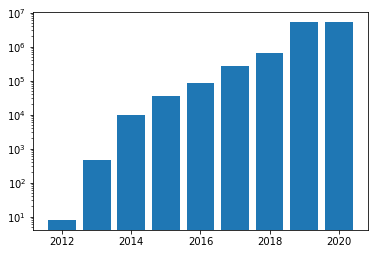

In [12]:
years_col_list = [str(y)+'_tweets' for y in range(2012,2021)]
sum_list = [df_indicators[y].sum() for y in years_col_list]
plt.bar(range(2012,2021), sum_list, log=True)

# Total number of tweets

In [13]:
tot_n_tweets = df_tweets.shape[0]
tot_n_tweets

11712348

# Total number of likes and comments and retweets

In [14]:
total_favorite = df_tweets.favorite_count.sum()
total_favorite

3366938

In [15]:
total_replies = df_tweets.reply_count.sum()
total_replies

129111

In [16]:
total_retweets = df_tweets.retweet_count.sum()
total_retweets

703435637

# Ratio between the number of tweets and the number of likes

In [17]:
ratio_tweets_fav = len(df_tweets) / total_favorite
ratio_tweets_fav

3.4786348902177586

## Ratio between the number of tweets and the number of retweets

In [18]:
ratio_tweets_rt = len(df_tweets) / total_retweets
ratio_tweets_rt

0.016650205624995938

## Ratio between the number of tweets and the number of comments

In [19]:
ratio_tweets_replies = len(df_tweets) / total_replies
ratio_tweets_replies

90.71533796500685

# Entropy of the user

In [20]:
from scipy.stats import entropy

lang_entropy = entropy(np.array(sum_list),base=2)

In [21]:
lang_entropy

1.4817996492336531

# Average length of the tweets per user

In [17]:
df_tweets['length'] = df_tweets.text.astype(str).apply(len)

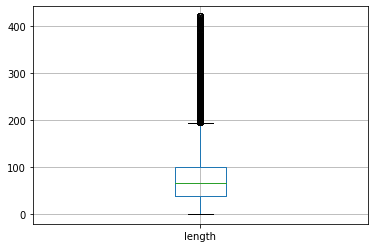

In [18]:
df_tweets.boxplot('length')

In [19]:
len_groupby = df_tweets.groupby('user_id').agg({'length':'mean'})

In [20]:
df_indicators['mean_length'] = len_groupby.length.values
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets,mean_length
0,0006qod9y,1,0,0,0,0,0,0,0,0,1,22.0
1,000unb,1,0,0,0,0,0,0,0,1,0,22.0
2,000vk,1,0,0,0,0,0,0,0,0,1,110.0
3,0013tom,1,0,0,0,0,0,0,1,0,0,104.0
4,001gi,1,0,0,0,0,0,0,0,0,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
222280,zzyd6,1,0,0,0,0,0,0,0,1,0,66.0
222281,zzyhkgc34,1,0,0,0,0,0,0,0,0,1,47.0
222282,zzyyu,1,0,0,0,0,0,0,0,0,1,64.0
222283,zzz9v,1,0,0,0,0,0,0,0,1,0,3.0


# Average number of special characters in the tweets per user

In [21]:
df_tweets['special_chars'] = df_tweets.text.astype(str).apply(lambda text: len(re.findall("(?=\W)(?=\S)", text)))

In [22]:
len_groupby = df_tweets.groupby('user_id').agg({'special_chars':'mean'})

df_indicators['mean_special_chars'] = len_groupby.special_chars.values
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets,mean_length,mean_special_chars
0,0006qod9y,1,0,0,0,0,0,0,0,0,1,22.0,1.0
1,000unb,1,0,0,0,0,0,0,0,1,0,22.0,1.0
2,000vk,1,0,0,0,0,0,0,0,0,1,110.0,9.0
3,0013tom,1,0,0,0,0,0,0,1,0,0,104.0,5.0
4,001gi,1,0,0,0,0,0,0,0,0,1,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222280,zzyd6,1,0,0,0,0,0,0,0,1,0,66.0,0.0
222281,zzyhkgc34,1,0,0,0,0,0,0,0,0,1,47.0,1.0
222282,zzyyu,1,0,0,0,0,0,0,0,0,1,64.0,1.0
222283,zzz9v,1,0,0,0,0,0,0,0,1,0,3.0,0.0


# File Checkpoint

In [ ]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [ ]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators.csv', sep='#', index=False)

# Mean and standard deviation for each attribute by user

In [23]:
user_groupby = df_tweets.groupby('user_id').agg(['mean','std'])

In [24]:
user_groupby.drop(columns=['index','length','special_chars'], inplace=True)

In [25]:
df_indicators[['retweets_count_mean','retweets_count_std',
              'reply_count_mean','reply_count_std',
              'favorite_count_mean','favorite_count_std',
              'num_hashtags_mean','num_hashtags_std',
              'num_urls_mean','num_urls_std',
              'num_mentions_mean','num_mentions_std',
              'created_at_mean','created_at_std']] = user_groupby.values

In [26]:
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,...,favorite_count_mean,favorite_count_std,num_hashtags_mean,num_hashtags_std,num_urls_mean,num_urls_std,num_mentions_mean,num_mentions_std,created_at_mean,created_at_std
0,0006qod9y,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,NaN,1.586192e+18,NaN
1,000unb,1,0,0,0,0,0,0,0,1,...,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,1.554839e+18,NaN
2,000vk,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,2.0,NaN,1.587992e+18,NaN
3,0013tom,1,0,0,0,0,0,0,1,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.523254e+18,NaN
4,001gi,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.586231e+18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222280,zzyd6,1,0,0,0,0,0,0,0,1,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.560955e+18,NaN
222281,zzyhkgc34,1,0,0,0,0,0,0,0,0,...,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.582163e+18,NaN
222282,zzyyu,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.585427e+18,NaN
222283,zzz9v,1,0,0,0,0,0,0,0,1,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.555416e+18,NaN


# Tweeting regularity
We want an indicator that can tell us if the user has a certain regularity in the publication.
We define the tweeting regularity of a user as:
$$ Var( \{\ timestamp_i - timestamp_j\ |\ j = i + 1 \} )$$

In [27]:
def tweeting_regularity(user_timestamps):
    user_timestamps = user_timestamps.values.sort()
    diffs = []
    for i in range(1,len(user_timestamps)):
        diffs.append(user_timestamps[i]-user_timestamps[i-1])
    diffs = np.array(diffs)
    return diffs.var()

df_tweets.groupby('user_id').agg({'created_at_conv': tweeting_regularity})

/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:436: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  key: obj._gotitem(key, ndim=1).agg(how) for key, how in arg.items()


TypeError: ignored

## Maximum number of tweets in a day by user

Add new column which represents the date as the number of the day in the year (e.g. 1st of Janueary would be 1, 2nd of January would be 2, [...], 31st of December would be 365 or 366) concatenated to the year.
For example, 2nd of January of 2019 would be "2_2019".

In [28]:
df_tweets['day_of_year'] = pd.DatetimeIndex(df_tweets.created_at).day_of_year.map(str) + "_" + pd.DatetimeIndex(df_tweets.created_at).year.map(str)

In [29]:
df_tweets['day_of_year']

0           254_2019
1            92_2020
2           122_2019
3           308_2019
4            71_2020
              ...   
11712343    124_2018
11712344    108_2020
11712345    192_2016
11712346     66_2019
11712347    191_2019
Name: day_of_year, Length: 11712348, dtype: object

In [30]:
user_date_groupby = pd.DataFrame({'n_tweets_by_day' : df_tweets.groupby( [ 'user_id', 'day_of_year'] ).size()}).reset_index()
#pd.DataFrame(df_tweets.groupby(['user_id', 'day_of_year'])['day_of_year'].agg('size'))

In [31]:
user_date_groupby

,user_id,day_of_year,n_tweets_by_day
0,0006qod9y,97_2020,1
1,000unb,99_2019,1
2,000vk,118_2020,1
3,0013tom,99_2018,1
4,001gi,98_2020,1
...,...,...,...
1267226,zzyd6,170_2019,1
1267227,zzyhkgc34,51_2020,1
1267228,zzyyu,88_2020,1
1267229,zzz9v,106_2019,1


In [32]:
# Maximum number of tweets in a day
user_date_groupby[user_date_groupby['n_tweets_by_day'] == user_date_groupby['n_tweets_by_day'].max()]

,user_id,day_of_year,n_tweets_by_day
243011,1939977158,122_2020,2268


Identify maximum number of tweets posted in a day for each user.

In [33]:
df_indicators['max_daily_tweets'] = user_date_groupby.groupby(by=['user_id']).agg({'n_tweets_by_day':max}).values